# Algorithm Implmentation

#### Notes


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import h5py
from IPython.display import Image

#### Project Links
* [Paper](https://arxiv.org/pdf/1506.02142.pdf)
* [Appendix](https://arxiv.org/pdf/1506.02157.pdf)
* [Authors' GitHub Repository](https://github.com/yaringal/DropoutUncertaintyCaffeModels)

In [2]:
# Read h5 file and format as a Pandas data frame
def read_h5_file(filename):
#     filename = 'test.h5'
    f = h5py.File(filename, 'r')
    data = [v for r in list(f['data']) for v in r]
    label = [v for r in list(f['label']) for v in r]
    return pd.DataFrame({'data': data, 'label': label})
    
# f = h5py.File('train.h5', 'r')
# List all groups
# print("Keys: %s" % f.keys())
# a_group_key = list(f.keys())[0]
# print(list(f.keys()))
# print(list(f['data']))
# print("-")
# print(list(f['label']))
# print(list(f))
# Get the data
# data = list(f[a_group_key])

train = read_h5_file('train.h5')
test = read_h5_file('test.h5')

In [3]:
print(train.info())
train.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 275 entries, 0 to 274
Data columns (total 2 columns):
data     275 non-null float64
label    275 non-null float64
dtypes: float64(2)
memory usage: 4.4 KB
None


,data,label
0,-1.727438,0.073381
1,-1.718201,0.176061
2,-1.708963,0.381420
3,-1.699725,0.381420
4,-1.690488,0.484099


In [4]:
print(test.info())
test.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 2 columns):
data     100 non-null float64
label    100 non-null float64
dtypes: float64(2)
memory usage: 1.6 KB
None


,data,label
0,-1.570398,-0.645374
1,-1.561161,-0.645374
2,-1.551923,-0.645374
3,-1.542685,-0.645374
4,-1.533448,-0.337336


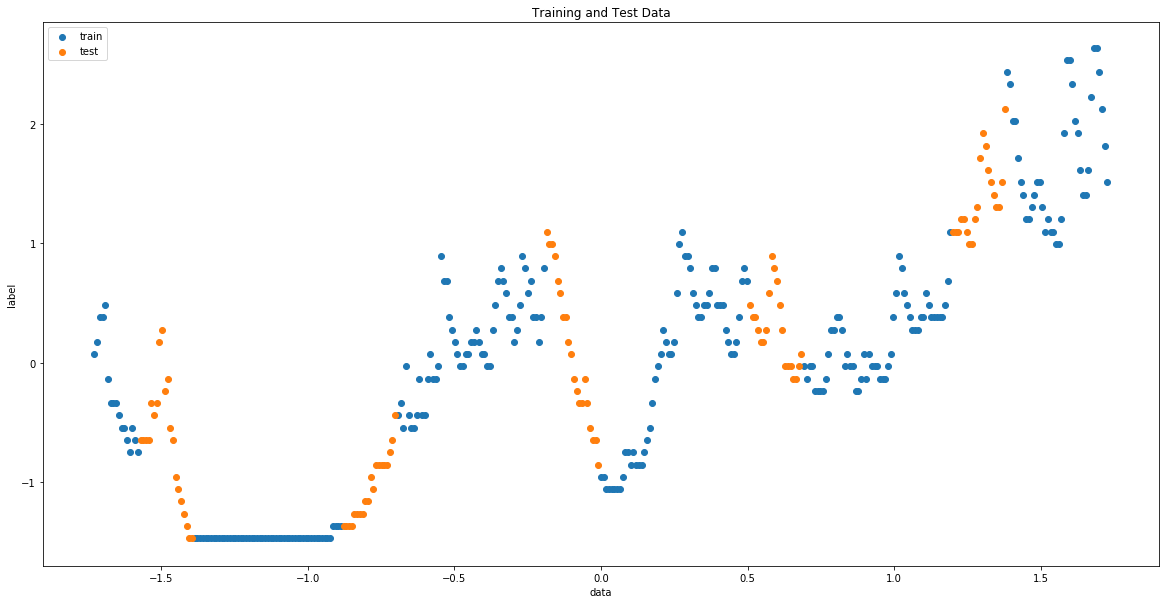

In [5]:
# Plot Training and Test Data
plt.figure(figsize=(20,10))
plt.scatter(train['data'], train['label'], label='train')
plt.scatter(test['data'], test['label'], label='test')
plt.xlabel('data')
plt.ylabel('label')
plt.title('Training and Test Data')
plt.legend()
plt.show()

#### Model Specifications from Paper
- ReLU Network
- 5 hidden layers
- 1024 hidden units in each layer
- Base learning rate 5e-3
- Weight decay 5e-7
- Otherwise, use the same parameters as the CO2 model:
- Stochastic gradient descent optimizer (run for 1,000,000 iterations / until convergence)
- Learning rate policy base:  lr * (1 + gamma * item)^-p
- Gamma = 0.0001, p = 0.25, momentum = 0.9
- Initialize the bias at 0
- Initialize weights uniformly from [-sqrt(3/fan-in), sqrt(3/fan-in)]
- No mini-batch optimization used, since the data is fairly small and with high frequencies
- Experimented with dropout probabilities of 0.1 and 0.2, but in the end, they both had about the same results, so it probably doesn’t matter that much
- However, it could be worth trying both on this model and see how the results change (if they do at all)
- Used T = 1000 forward iterations to estimate the uncertainty for drawing purposes
- However, they claim they could have gotten reasonable estimates using only T = 10
- Loss function = Euclidean loss

In [27]:
# Fit model according to specification in paper
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Activation
from keras.optimizers import SGD
import keras.backend as K
from keras.callbacks import Callback

full = train.append(test)

# Euclidean loss function--obtained from:
# http://www.riptutorial.com/keras/example/32022/euclidean-distance-loss
def euclidean_distance_loss(y_true, y_pred):
    """
    Euclidean distance loss
    https://en.wikipedia.org/wiki/Euclidean_distance
    :param y_true: TensorFlow/Theano tensor
    :param y_pred: TensorFlow/Theano tensor of the same shape as y_true
    :return: float
    """
    return K.sqrt(K.sum(K.square(y_pred - y_true), axis=-1))

# Based off of examples from:
# 1. https://machinelearningmastery.com/dropout-regularization-deep-learning-models-keras/
# 2. https://keras.io/getting-started/sequential-model-guide/#compilation

# Create NN dropout model
def create_model():
    # Create model
    model = Sequential()
    # Layer 1
    model.add(Dense(1024, input_dim=1, kernel_initializer='lecun_uniform', activation='relu'))
    model.add(Dropout(0.1))
    # Layer 2
    model.add(Dense(1024, kernel_initializer='lecun_uniform', activation='relu'))
    model.add(Dropout(0.1))
    # Layer 3
    model.add(Dense(1024, kernel_initializer='lecun_uniform', activation='relu'))
    model.add(Dropout(0.1))
    # Layer 4
    model.add(Dense(1024, kernel_initializer='lecun_uniform', activation='relu'))
    model.add(Dropout(0.1))
    # Layer 5
    model.add(Dense(1, kernel_initializer='lecun_uniform'))
    
    # Compile model
    sgd = SGD(lr=5e-3, momentum=0.9, decay=5e-7, nesterov=False)
    model.compile(loss=euclidean_distance_loss, optimizer=sgd)
    return model

# Save predictions from every epoch
# Code from: https://stackoverflow.com/questions/36895627/python-keras-creating-a-callback-with-one-prediction-for-each-epoch?noredirect=1&lq=1
class prediction_history(Callback):
    def __init__(self):
        self.predhis = []
    def on_epoch_end(self, epoch, logs={}):
        self.predhis.append(model.predict(full['data']))

In [28]:
# Train the model, iterating on the data in batches of 32 
nepochs = 1000
model = create_model()
# model.fit(x=train['data'], y=train['label'], epochs=1000, batch_size=32)

#Calling the subclass
predictions=prediction_history()

#Executing the model.fit of the neural network
model.fit(x=train['data'], y=train['label'], epochs=nepochs, batch_size=32, callbacks=[predictions])

#Printing the prediction history
# print(predictions.predhis)

Epoch 1/1000
275/275 [==============================] - 0s 2ms/step - loss: 0.6777
Epoch 2/1000
275/275 [==============================] - 0s 1ms/step - loss: 0.5848
Epoch 3/1000
275/275 [==============================] - 0s 1ms/step - loss: 0.5678
Epoch 4/1000
275/275 [==============================] - 0s 1ms/step - loss: 0.5886
Epoch 5/1000
275/275 [==============================] - 0s 1ms/step - loss: 0.6193
Epoch 6/1000
275/275 [==============================] - 0s 1ms/step - loss: 0.6279
Epoch 7/1000
275/275 [==============================] - 0s 1ms/step - loss: 0.5904
Epoch 8/1000
275/275 [==============================] - 0s 1ms/step - loss: 0.5829
Epoch 9/1000
275/275 [==============================] - 0s 1ms/step - loss: 0.6329
Epoch 10/1000
275/275 [==============================] - 0s 1ms/step - loss: 0.5665
Epoch 11/1000
275/275 [==============================] - 0s 1ms/step - loss: 0.5775
Epoch 12/1000
275/275 [==============================] - 0s 1ms/step - loss: 0.5860
E

275/275 [==============================] - 0s 1ms/step - loss: 0.5243
Epoch 99/1000
275/275 [==============================] - 0s 1ms/step - loss: 0.5422
Epoch 100/1000
275/275 [==============================] - 0s 1ms/step - loss: 0.5099
Epoch 101/1000
275/275 [==============================] - 0s 1ms/step - loss: 0.4932
Epoch 102/1000
275/275 [==============================] - 0s 1ms/step - loss: 0.4975
Epoch 103/1000
275/275 [==============================] - 0s 1ms/step - loss: 0.4825
Epoch 104/1000
275/275 [==============================] - 0s 1ms/step - loss: 0.5204
Epoch 105/1000
275/275 [==============================] - 0s 1ms/step - loss: 0.5055
Epoch 106/1000
275/275 [==============================] - 0s 1ms/step - loss: 0.5126
Epoch 107/1000
275/275 [==============================] - 0s 1ms/step - loss: 0.5014
Epoch 108/1000
275/275 [==============================] - 0s 1ms/step - loss: 0.4951
Epoch 109/1000
275/275 [==============================] - 0s 1ms/step - loss: 0.4

275/275 [==============================] - 0s 1ms/step - loss: 0.2987
Epoch 195/1000
275/275 [==============================] - 0s 1ms/step - loss: 0.3108
Epoch 196/1000
275/275 [==============================] - 0s 1ms/step - loss: 0.3073
Epoch 197/1000
275/275 [==============================] - 0s 1ms/step - loss: 0.2976
Epoch 198/1000
275/275 [==============================] - 0s 2ms/step - loss: 0.3007
Epoch 199/1000
275/275 [==============================] - 0s 1ms/step - loss: 0.3161
Epoch 200/1000
275/275 [==============================] - 0s 1ms/step - loss: 0.2933
Epoch 201/1000
275/275 [==============================] - 0s 1ms/step - loss: 0.2796
Epoch 202/1000
275/275 [==============================] - 0s 1ms/step - loss: 0.3109
Epoch 203/1000
275/275 [==============================] - 0s 1ms/step - loss: 0.2996
Epoch 204/1000
275/275 [==============================] - 0s 1ms/step - loss: 0.2862
Epoch 205/1000
275/275 [==============================] - 0s 1ms/step - loss: 0.

275/275 [==============================] - 0s 1ms/step - loss: 0.2534
Epoch 291/1000
275/275 [==============================] - 0s 1ms/step - loss: 0.2719
Epoch 292/1000
275/275 [==============================] - 0s 1ms/step - loss: 0.2597
Epoch 293/1000
275/275 [==============================] - 0s 1ms/step - loss: 0.2684
Epoch 294/1000
275/275 [==============================] - 0s 1ms/step - loss: 0.2758
Epoch 295/1000
275/275 [==============================] - 0s 1ms/step - loss: 0.2533
Epoch 296/1000
275/275 [==============================] - 0s 1ms/step - loss: 0.2697
Epoch 297/1000
275/275 [==============================] - 0s 1ms/step - loss: 0.2565
Epoch 298/1000
275/275 [==============================] - 0s 1ms/step - loss: 0.2433
Epoch 299/1000
275/275 [==============================] - 0s 1ms/step - loss: 0.2359
Epoch 300/1000
275/275 [==============================] - 0s 2ms/step - loss: 0.2328
Epoch 301/1000
275/275 [==============================] - 0s 1ms/step - loss: 0.

275/275 [==============================] - 0s 1ms/step - loss: 0.2593
Epoch 387/1000
275/275 [==============================] - 0s 1ms/step - loss: 0.2380
Epoch 388/1000
275/275 [==============================] - 0s 1ms/step - loss: 0.2330
Epoch 389/1000
275/275 [==============================] - 0s 1ms/step - loss: 0.2348
Epoch 390/1000
275/275 [==============================] - 0s 1ms/step - loss: 0.2361
Epoch 391/1000
275/275 [==============================] - 0s 1ms/step - loss: 0.2635
Epoch 392/1000
275/275 [==============================] - 0s 1ms/step - loss: 0.2515
Epoch 393/1000
275/275 [==============================] - 0s 1ms/step - loss: 0.2500
Epoch 394/1000
275/275 [==============================] - 0s 1ms/step - loss: 0.2266
Epoch 395/1000
275/275 [==============================] - 0s 1ms/step - loss: 0.2316
Epoch 396/1000
275/275 [==============================] - 0s 1ms/step - loss: 0.2582
Epoch 397/1000
275/275 [==============================] - 0s 1ms/step - loss: 0.

275/275 [==============================] - 0s 1ms/step - loss: 0.2236
Epoch 483/1000
275/275 [==============================] - 0s 1ms/step - loss: 0.2276
Epoch 484/1000
275/275 [==============================] - 0s 1ms/step - loss: 0.2244
Epoch 485/1000
275/275 [==============================] - 0s 1ms/step - loss: 0.2251
Epoch 486/1000
275/275 [==============================] - 0s 1ms/step - loss: 0.2294
Epoch 487/1000
275/275 [==============================] - 0s 1ms/step - loss: 0.2208
Epoch 488/1000
275/275 [==============================] - 0s 1ms/step - loss: 0.2349
Epoch 489/1000
275/275 [==============================] - 0s 1ms/step - loss: 0.2655
Epoch 490/1000
275/275 [==============================] - 0s 1ms/step - loss: 0.2710
Epoch 491/1000
275/275 [==============================] - 0s 1ms/step - loss: 0.2723
Epoch 492/1000
275/275 [==============================] - 0s 1ms/step - loss: 0.2688
Epoch 493/1000
275/275 [==============================] - 0s 1ms/step - loss: 0.

275/275 [==============================] - 0s 1ms/step - loss: 0.2532
Epoch 579/1000
275/275 [==============================] - 0s 1ms/step - loss: 0.2448
Epoch 580/1000
275/275 [==============================] - 0s 1ms/step - loss: 0.2455
Epoch 581/1000
275/275 [==============================] - 0s 1ms/step - loss: 0.2251
Epoch 582/1000
275/275 [==============================] - 0s 1ms/step - loss: 0.2624
Epoch 583/1000
275/275 [==============================] - 0s 1ms/step - loss: 0.2199
Epoch 584/1000
275/275 [==============================] - 0s 1ms/step - loss: 0.2325
Epoch 585/1000
275/275 [==============================] - 0s 1ms/step - loss: 0.2421
Epoch 586/1000
275/275 [==============================] - 0s 1ms/step - loss: 0.2229
Epoch 587/1000
275/275 [==============================] - 0s 1ms/step - loss: 0.2110
Epoch 588/1000
275/275 [==============================] - 0s 1ms/step - loss: 0.2130
Epoch 589/1000
275/275 [==============================] - 0s 1ms/step - loss: 0.

275/275 [==============================] - 0s 1ms/step - loss: 0.2797
Epoch 675/1000
275/275 [==============================] - 0s 1ms/step - loss: 0.2391
Epoch 676/1000
275/275 [==============================] - 0s 1ms/step - loss: 0.2212
Epoch 677/1000
275/275 [==============================] - 0s 1ms/step - loss: 0.2365
Epoch 678/1000
275/275 [==============================] - 0s 1ms/step - loss: 0.2282
Epoch 679/1000
275/275 [==============================] - 0s 1ms/step - loss: 0.2615
Epoch 680/1000
275/275 [==============================] - 0s 1ms/step - loss: 0.2233
Epoch 681/1000
275/275 [==============================] - 0s 1ms/step - loss: 0.2588
Epoch 682/1000
275/275 [==============================] - 0s 1ms/step - loss: 0.2319
Epoch 683/1000
275/275 [==============================] - 0s 1ms/step - loss: 0.2428
Epoch 684/1000
275/275 [==============================] - 0s 1ms/step - loss: 0.2288
Epoch 685/1000
275/275 [==============================] - 0s 1ms/step - loss: 0.

275/275 [==============================] - 0s 1ms/step - loss: 0.2415
Epoch 770/1000
275/275 [==============================] - 0s 1ms/step - loss: 0.2333
Epoch 771/1000
275/275 [==============================] - 0s 1ms/step - loss: 0.2216
Epoch 772/1000
275/275 [==============================] - 0s 978us/step - loss: 0.2173
Epoch 773/1000
275/275 [==============================] - 0s 985us/step - loss: 0.2611
Epoch 774/1000
275/275 [==============================] - 0s 1ms/step - loss: 0.2692
Epoch 775/1000
275/275 [==============================] - 0s 971us/step - loss: 0.2543
Epoch 776/1000
275/275 [==============================] - 0s 989us/step - loss: 0.2395
Epoch 777/1000
275/275 [==============================] - 0s 1ms/step - loss: 0.2204
Epoch 778/1000
275/275 [==============================] - 0s 1ms/step - loss: 0.2259
Epoch 779/1000
275/275 [==============================] - 0s 1ms/step - loss: 0.2258
Epoch 780/1000
275/275 [==============================] - 0s 1ms/step - 

275/275 [==============================] - 0s 1ms/step - loss: 0.2746
Epoch 866/1000
275/275 [==============================] - 0s 1ms/step - loss: 0.2468
Epoch 867/1000
275/275 [==============================] - 0s 1ms/step - loss: 0.2235
Epoch 868/1000
275/275 [==============================] - 0s 1ms/step - loss: 0.2160
Epoch 869/1000
275/275 [==============================] - 0s 1ms/step - loss: 0.2357
Epoch 870/1000
275/275 [==============================] - 0s 1ms/step - loss: 0.2443
Epoch 871/1000
275/275 [==============================] - 0s 1ms/step - loss: 0.2221
Epoch 872/1000
275/275 [==============================] - 0s 1ms/step - loss: 0.2389
Epoch 873/1000
275/275 [==============================] - 0s 2ms/step - loss: 0.2439
Epoch 874/1000
275/275 [==============================] - 0s 1ms/step - loss: 0.2149
Epoch 875/1000
275/275 [==============================] - 0s 1ms/step - loss: 0.2266
Epoch 876/1000
275/275 [==============================] - 0s 1ms/step - loss: 0.

275/275 [==============================] - 0s 1ms/step - loss: 0.2223
Epoch 962/1000
275/275 [==============================] - 0s 1ms/step - loss: 0.2341
Epoch 963/1000
275/275 [==============================] - 0s 1ms/step - loss: 0.2221
Epoch 964/1000
275/275 [==============================] - 0s 1ms/step - loss: 0.1991
Epoch 965/1000
275/275 [==============================] - 0s 1ms/step - loss: 0.2254
Epoch 966/1000
275/275 [==============================] - 0s 1ms/step - loss: 0.2067
Epoch 967/1000
275/275 [==============================] - 0s 1ms/step - loss: 0.2201
Epoch 968/1000
275/275 [==============================] - 0s 1ms/step - loss: 0.2207
Epoch 969/1000
275/275 [==============================] - 0s 1ms/step - loss: 0.2189
Epoch 970/1000
275/275 [==============================] - 0s 1ms/step - loss: 0.2311
Epoch 971/1000
275/275 [==============================] - 0s 1ms/step - loss: 0.2297
Epoch 972/1000
275/275 [==============================] - 0s 1ms/step - loss: 0.

In [29]:
len(predictions.predhis[0])

375

In [30]:
# train.append(test).shape
# full = train.append(test)
full['pred'] = model.predict(full['data'])

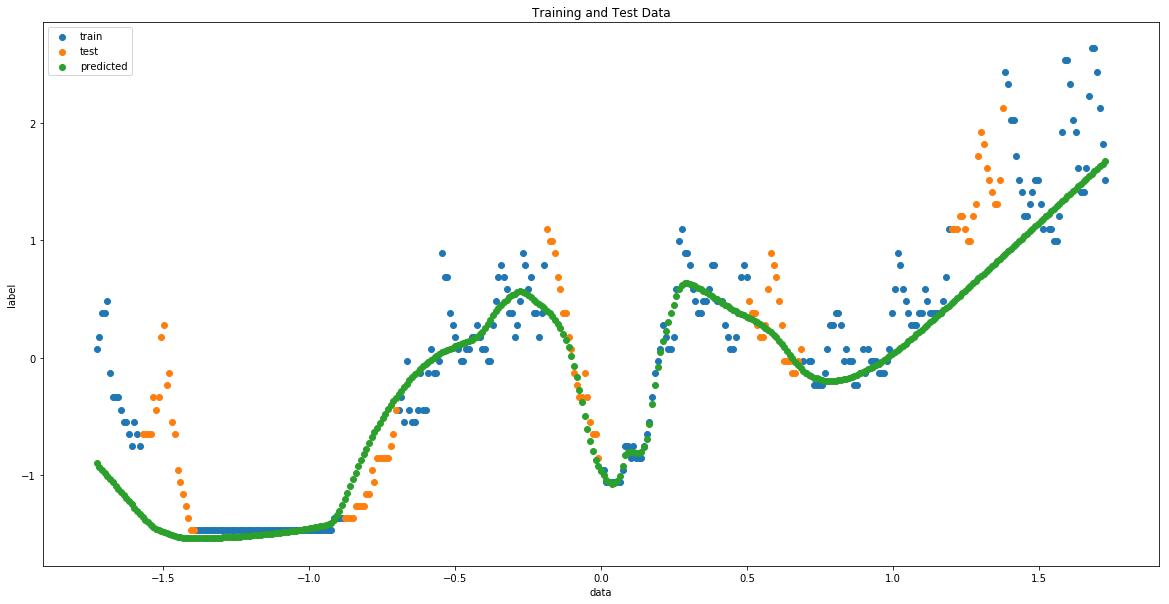

In [31]:
# Plot the predicted vs. actual values
plt.figure(figsize=(20,10))
plt.scatter(train['data'], train['label'], label='train')
plt.scatter(test['data'], test['label'], label='test')
plt.scatter(full['data'], full['pred'], label='predicted')
plt.xlabel('data')
plt.ylabel('label')
plt.title('Training and Test Data')
plt.legend()
plt.show()

In [32]:
# Reformat recorded predictions into a list, where each element is a numpy array
# of the predictions for a given variable from every pass
value_preds = []
for i in range(len(predictions.predhis[0])):
    value_pred_set = []
    for j in range(len(predictions.predhis)):
        value_pred_set.append(np.array(predictions.predhis[j][i]))
    value_preds.append(np.array(value_pred_set))

#### Formula for Variance
Using the following formulas from the paper to compute the variance (found in section 4 of the paper):

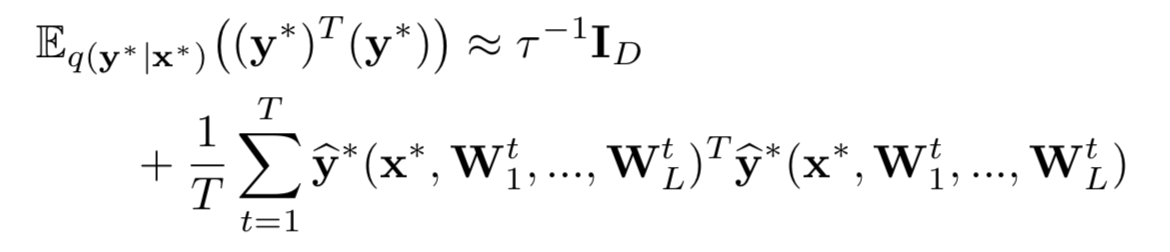

In [33]:
Image(filename='Images/Expectation.png')

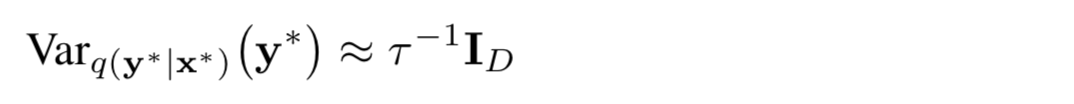

In [34]:
Image(filename='Images/Variance 1.png')

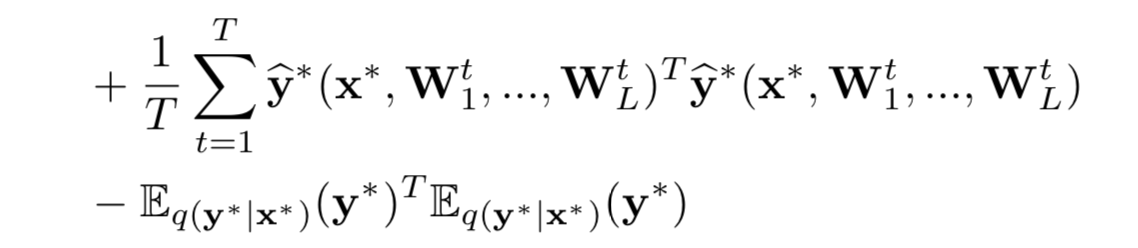

In [35]:
Image(filename='Images/Variance 2.png')

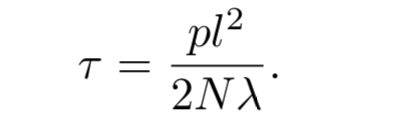

In [36]:
Image(filename='Images/Tau.png')

In [37]:
# Compute the variance for each observation
def ET(tau_inv, yhat):
    return tau_inv + 1 / len(yhat) * np.sum(np.dot(yhat.T, yhat))

def E(yhat):
    return 1 / len(yhat) * np.sum(yhat)

def VAR(tau_inv, yhat):
    return tau_inv + 1 / len(yhat) * np.sum(np.dot(yhat.T, yhat)) - ET(tau_inv, yhat) * E(yhat)

# Compute 2 * SD for the data point
def two_SD(tau_inv, yhat):
    return 2 * np.sqrt(VAR(tau_inv, yhat))

N = len(full)
lambda_val = 5e-7
p = 0.25
l = 1 # Random, user-chosen value
tau_inv = (2 * N * lambda_val) / (p * l**2)

# E(tau_inv, value_preds[0])
# # np.sum(np.dot(value_preds[0].T, value_preds[0]))
# VAR(tau_inv, value_preds[0])

In [38]:
# Get 2-sigma envelope
# full_pred = list(full['pred'])
# upper = [full_pred[i] + two_SD(tau_inv, value_preds[i]) for i in range(len(full_pred))]
# upper
print("tau_inv:", tau_inv)

a = []
for i in range(len(value_preds)):
# for i in range(1):
#     print(np.mean(value_preds[i]))
#     print("tau_inv:", tau_inv)
#     print("value_preds[i]:", len(value_preds[i]))
#     print("E(tau_inv, yhat):", E(tau_inv, value_preds[i]))
#     print("VAR(tau_inv, value_preds[i]):", VAR(tau_inv, value_preds[i]))
#     print('-' * 50)
    a.append(VAR(tau_inv, value_preds[i]))
#     print(VAR(tau_inv, value_preds[i]))

pd.Series(a).describe()

tau_inv: 0.0015


count    3.750000e+02
mean    -1.184438e+15
std      1.682899e+16
min     -9.007534e+16
25%     -2.446153e-04
50%      1.435085e-03
75%      3.244074e-03
max      8.813698e+16
dtype: float64

Problem above: variances are negative in some cases

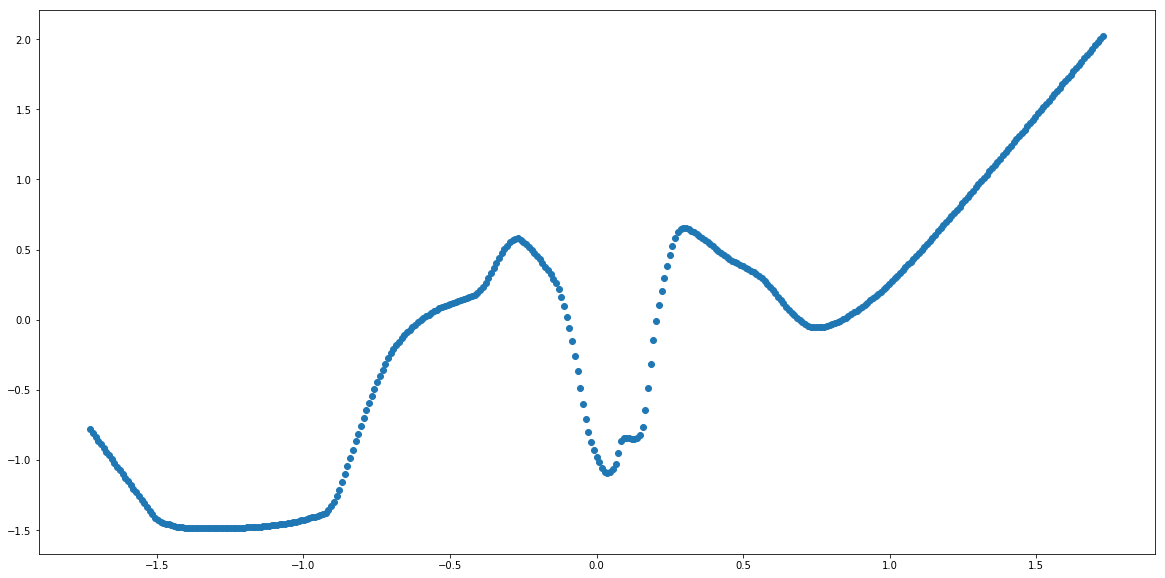

In [39]:
b = []
for i in range(len(value_preds)):
#     b.append(np.mean(value_preds[i]))
    b.append(value_preds[i][900])

plt.figure(figsize=(20, 10))
plt.scatter(full['data'], b)
plt.show()